In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/labels120.npy",tr_labels)


Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_dir = "/content/drive/MyDrive/"
data = np.load("data120.npy")
labels = np.load("labels120.npy", allow_pickle=True)
print(labels)

['Lung adenocarcinoma' 'Lung adenocarcinoma' 'Lung adenocarcinoma' ...
 'Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma']


In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Converting string labels to integers
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(labels)

# Converting integer labels to one-hot encoded labels
labels_one_hot = to_categorical(labels_int)

2024-03-10 11:37:50.098058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 11:37:50.098224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 11:37:50.101640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Visualizing Sample Images

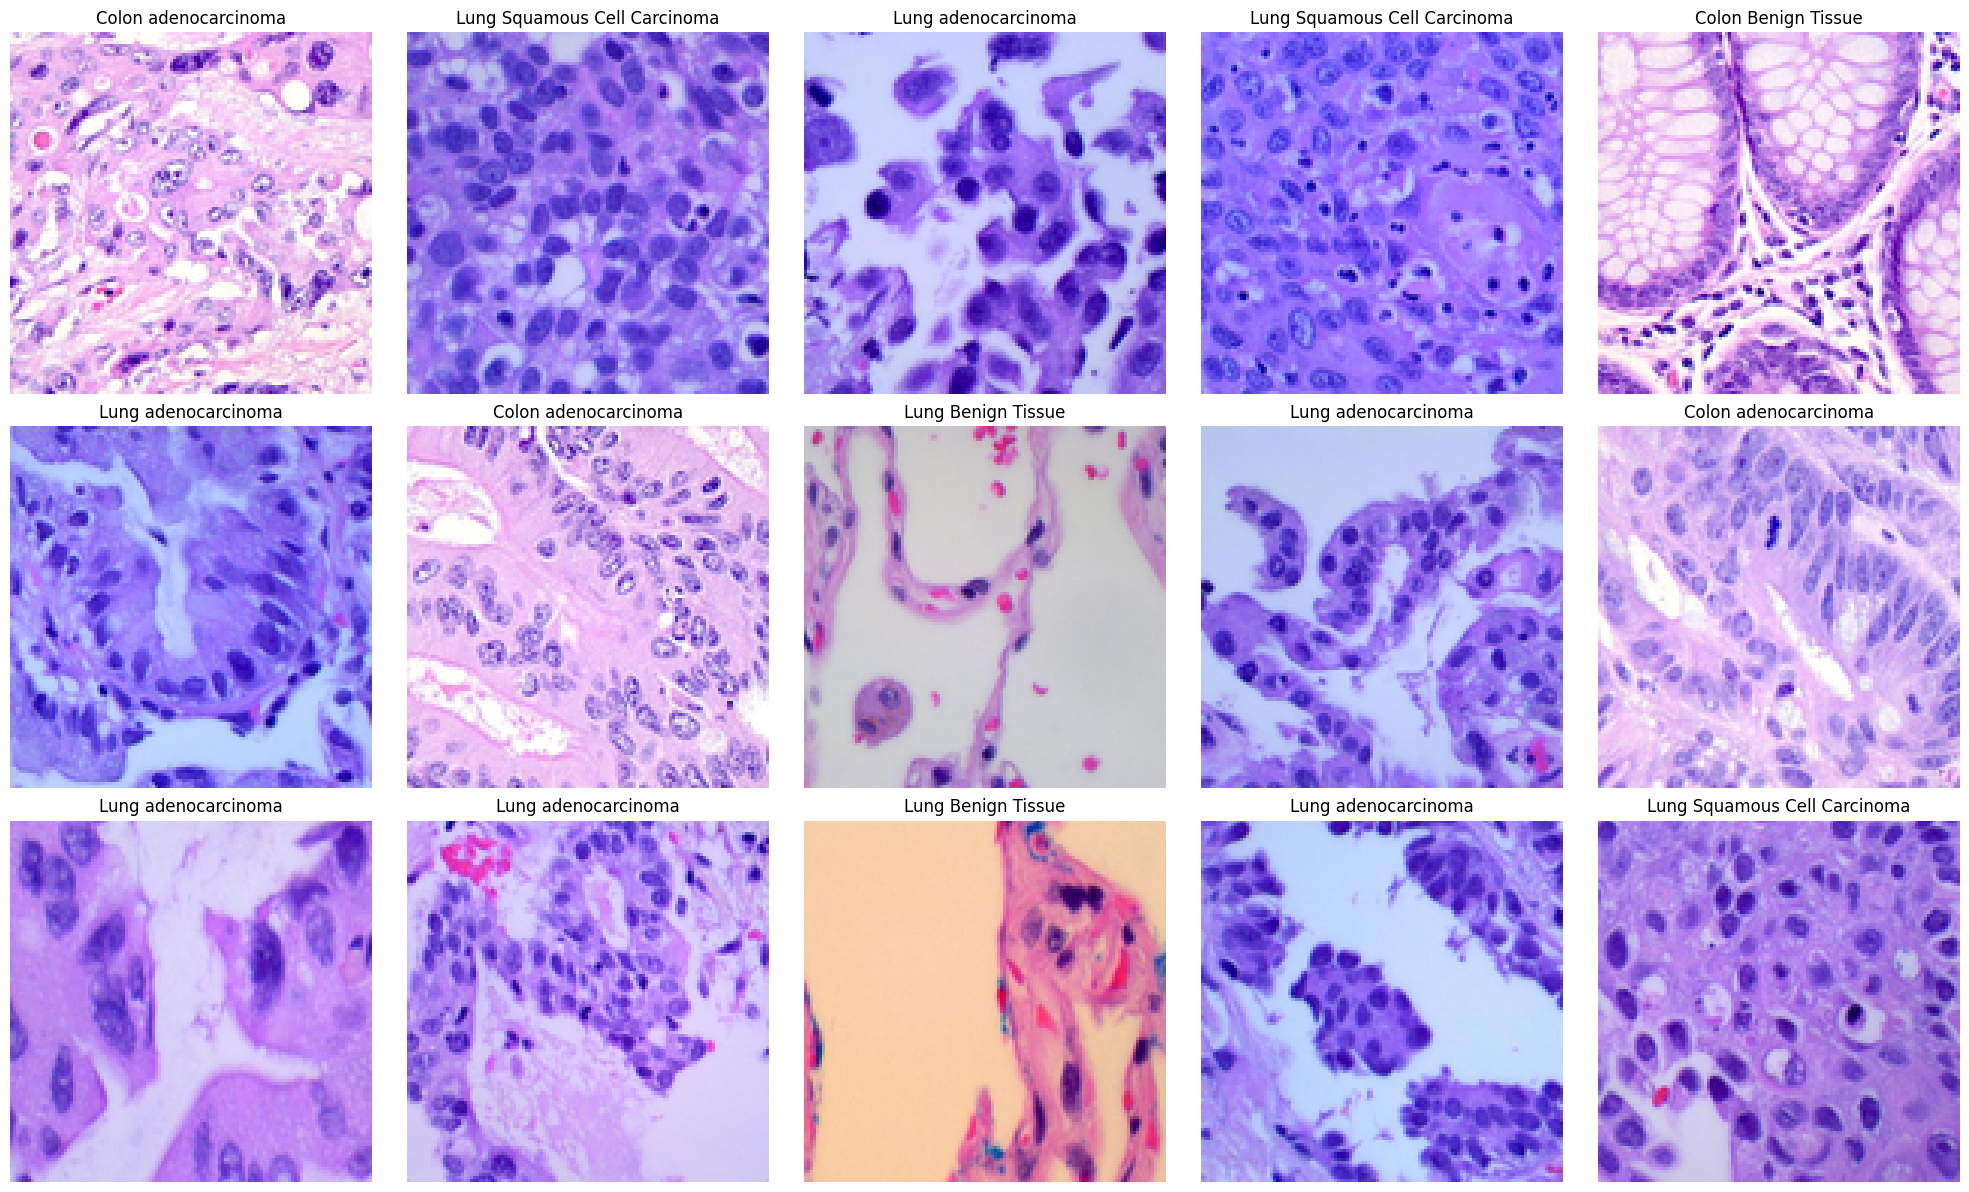

In [4]:
num_samples = 15
indices = np.random.choice(len(data), num_samples, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust the layout as needed
axes = axes.ravel()  # Flatten the axes array for easy indexing

for i, idx in enumerate(indices):
    img = data[idx]
    label = labels[idx] #labels should be the encoded one?
    axes[i].imshow(img.astype('uint8'))  # Display the image
    axes[i].set_title(label)  # Set the title to the corresponding label
    axes[i].axis('off')  # Hide the axes ticks

plt.tight_layout()
plt.show()


## Visualizing Class Distribution

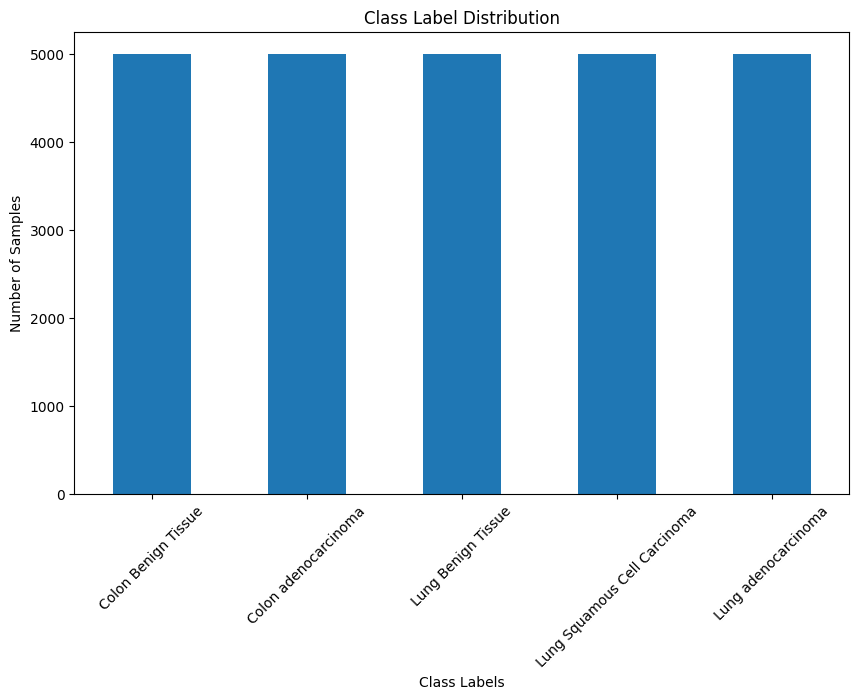

In [5]:
label_series = pd.Series(labels)
label_counts = label_series.value_counts()

# Sort the label counts for better visualization
label_counts = label_counts.sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
label_counts.plot(kind='bar')
plt.title('Class Label Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.show()

##Train-Test-Val Split

In [4]:
#Splitting Data into Train 60% Validation 20% and Test 20%

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels_one_hot, test_size=0.4, random_state=42, stratify=labels_one_hot)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [5]:
## LOSS-ACC GRAPHS function:

import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [6]:
#Conf matrix and Classification Report functions:

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, encoder, title='Confusion Matrix'):
    # Assuming y_true and y_pred are already in the form of integer labels
    conf_mat = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="magma",
                 yticklabels=encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))



In [7]:
#ROC curves function:

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def plot_multiclass_roc(model, X_test, y_test, n_classes, title='ROC on multi-class'):
    # Binarize the labels for OvR
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))
    y_pred = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()



# Baseline Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# input shape based on dataset's image dimensions and channels
input_shape = (120, 120, 3) 

# Number of classes
num_classes = 5  

model = Sequential([
    Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # softmax for multiclass classification
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # Suitable for multiclass classification
              metrics=['accuracy'])

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [11]:
import warnings
warnings.filterwarnings('ignore')

#Fitting the Baseline model

Baseline_hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

2024-03-09 18:48:17.464520: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.
2024-03-09 18:48:18.182800: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/10


2024-03-09 18:48:19.163380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-09 18:48:19.506222: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 18:48:19.956670: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 18:48:20.039689: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9340045350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 18:48:20.039724: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-03-09 18:48:20.048759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-09 18:48:20.130582: I ./tensorflow/compiler/j

469/469 [==============================] - 14s 24ms/step - loss: 6.8294 - accuracy: 0.5127 - val_loss: 1.2029 - val_accuracy: 0.4292
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.7346 - accuracy: 0.6388 - val_loss: 0.6260 - val_accuracy: 0.6942
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 0.6401 - accuracy: 0.6935 - val_loss: 0.6423 - val_accuracy: 0.7208
Epoch 4/10
469/469 [==============================] - 10s 22ms/step - loss: 0.5633 - accuracy: 0.7323 - val_loss: 0.6861 - val_accuracy: 0.6816
Epoch 5/10
469/469 [==============================] - 11s 22ms/step - loss: 0.5445 - accuracy: 0.7447 - val_loss: 0.7965 - val_accuracy: 0.7148
Epoch 6/10
469/469 [==============================] - 10s 22ms/step - loss: 0.4781 - accuracy: 0.7845 - val_loss: 0.6562 - val_accuracy: 0.7334
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.4345 - accuracy: 0.8105 - val_loss: 0.6698 - val_accuracy: 0.7598
Epo

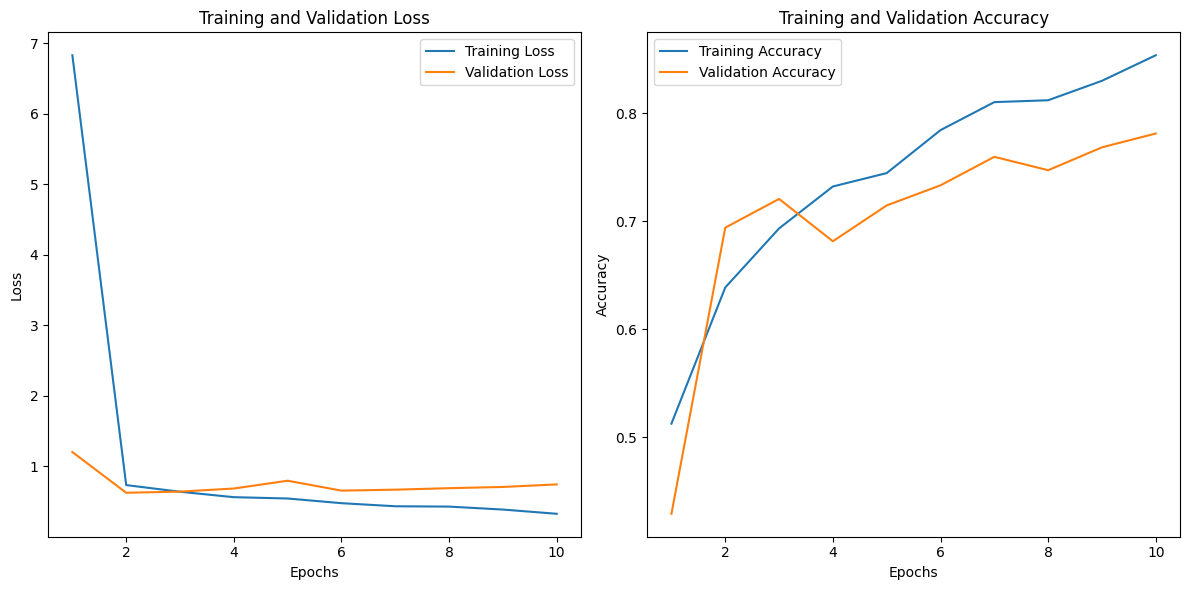

In [12]:
#Evaluating Loss and Accuracy of the Baseline model

plot_loss_accuracy(Baseline_hist)



In [13]:
#Predictions with Basemodel

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

#Decoding
y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

157/157 [==============================] - 1s 7ms/step


157/157 [==============================] - 1s 9ms/step


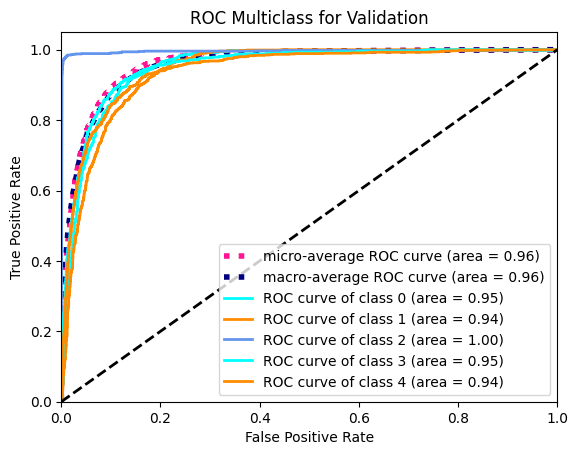

157/157 [==============================] - 1s 7ms/step


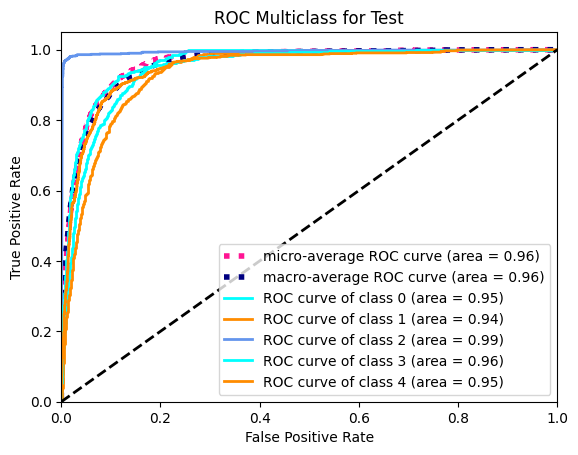

In [14]:
#ROC Curve analysis of Baseline model

plot_multiclass_roc(model, X_val, y_val, n_classes=5, title='ROC Multiclass for Validation')
plot_multiclass_roc(model, X_test, y_test, n_classes=5, title='ROC Multiclass for Test')



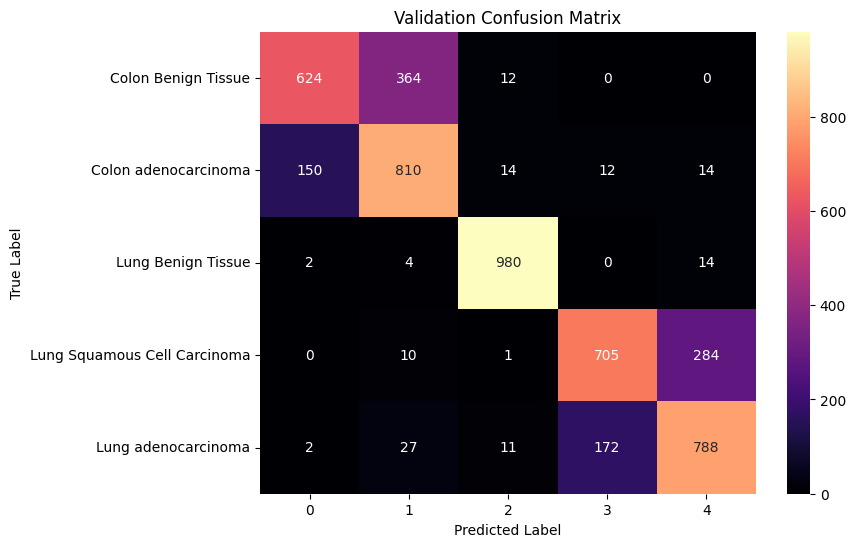

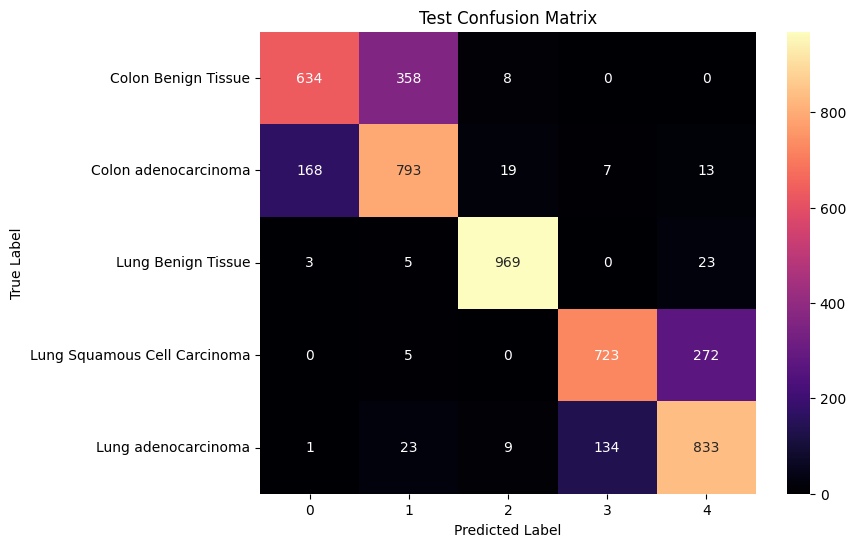

In [15]:
# Confusion matrix for the Baseline model

plot_confusion_matrix(y_val_decoded, y_val_pred_decoded, label_encoder,title= 'Validation Confusion Matrix')
plot_confusion_matrix(y_test_decoded, y_test_pred_decoded, label_encoder,title= 'Test Confusion Matrix')


In [16]:
#Performance Measure Report Baseline Model

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1000
           1       0.67      0.81      0.73      1000
           2       0.96      0.98      0.97      1000
           3       0.79      0.70      0.75      1000
           4       0.72      0.79      0.75      1000

    accuracy                           0.78      5000
   macro avg       0.79      0.78      0.78      5000
weighted avg       0.79      0.78      0.78      5000

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1000
           1       0.67      0.79      0.73      1000
           2       0.96      0.97      0.97      1000
           3       0.84      0.72      0.78      1000
           4       0.73      0.83      0.78      1000

    accuracy                           0.79      5000
   macro avg       0.80      0.79      0.79      5000
weighted avg       0.80      0.79      0.79      5000



# Enhanced Model

In [10]:
#Best Fine-tuned Model
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam , Adamax, RMSprop, SGD
from tensorflow.keras.regularizers import l1 , l2 , l1_l2


input_shape = (120, 120, 3) 
num_classes = 5  

model_enhanced = Sequential([
    Conv2D(256, (3, 3), activation='relu',padding='same', input_shape=input_shape, kernel_regularizer = l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu',padding='same',kernel_regularizer = l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu',padding='same',kernel_regularizer = l2(0.001)),
    MaxPooling2D((2, 2)),
    #Dropout(0.1),
    Conv2D(32, (3, 3), activation='relu',padding='same',kernel_regularizer = l2(0.001)),
    MaxPooling2D((2, 2)),
    #Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer = l2(0.001)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  
])

model_enhanced.compile(optimizer=Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

model_enhanced.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 256)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 60, 60, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 128)      

In [11]:
#Fitting the Best Fine-tuned Model

import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping

# Definning the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

# Fitting the model with more epochs and the early stopping callback
Enhanced_hist = model_enhanced.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping])

Epoch 1/15


2024-03-09 19:33:03.716089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 35s 71ms/step - loss: 1.4139 - accuracy: 0.6430 - val_loss: 0.9228 - val_accuracy: 0.7618
Epoch 2/15
469/469 [==============================] - 32s 68ms/step - loss: 0.8467 - accuracy: 0.7929 - val_loss: 0.7936 - val_accuracy: 0.8360
Epoch 3/15
469/469 [==============================] - 31s 67ms/step - loss: 0.6762 - accuracy: 0.8620 - val_loss: 0.5739 - val_accuracy: 0.9124
Epoch 4/15
469/469 [==============================] - 31s 66ms/step - loss: 0.5706 - accuracy: 0.9027 - val_loss: 0.6037 - val_accuracy: 0.8850
Epoch 5/15
469/469 [==============================] - 30s 65ms/step - loss: 0.5093 - accuracy: 0.9204 - val_loss: 0.4675 - val_accuracy: 0.9380
Epoch 6/15
469/469 [==============================] - 30s 64ms/step - loss: 0.4522 - accuracy: 0.9363 - val_loss: 0.4467 - val_accuracy: 0.9368
Epoch 7/15
469/469 [==============================] - 29s 63ms/step - loss: 0.4248 - accuracy: 0.9431 - val_loss: 0.4438 - val_accuracy: 0.9356
Epo

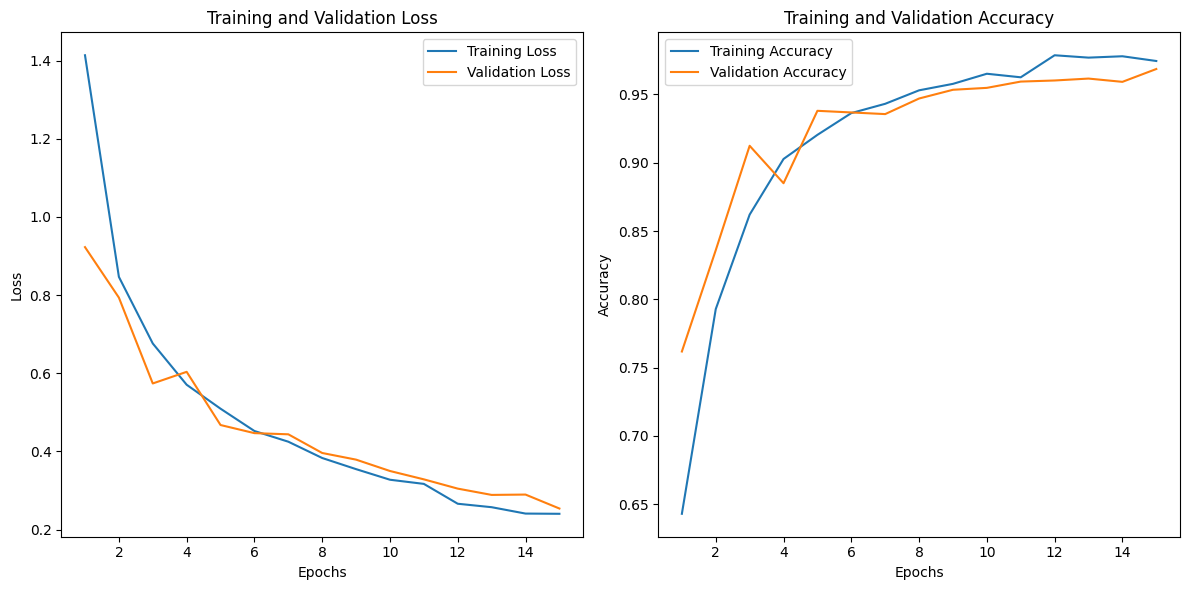

In [12]:
#Evaluating Loss and Accuracy of the Best Fine-tuned Model

plot_loss_accuracy(Enhanced_hist)

In [13]:
#Predictions with Best Fine-tuned Model

y_val_pred = model_enhanced.predict(X_val)
y_test_pred = model_enhanced.predict(X_test)
#Decoding the prediction
y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

157/157 [==============================] - 2s 14ms/step


157/157 [==============================] - 2s 14ms/step


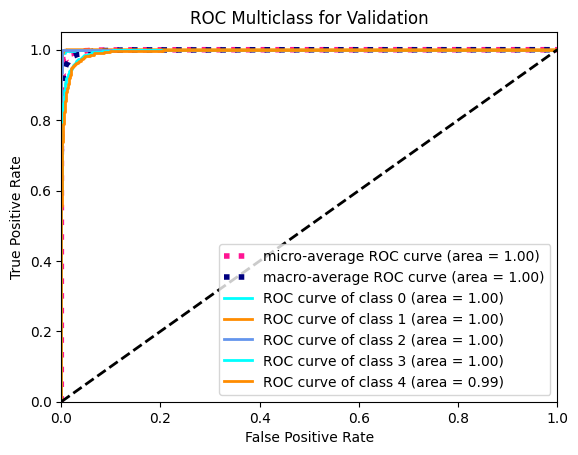

157/157 [==============================] - 2s 14ms/step


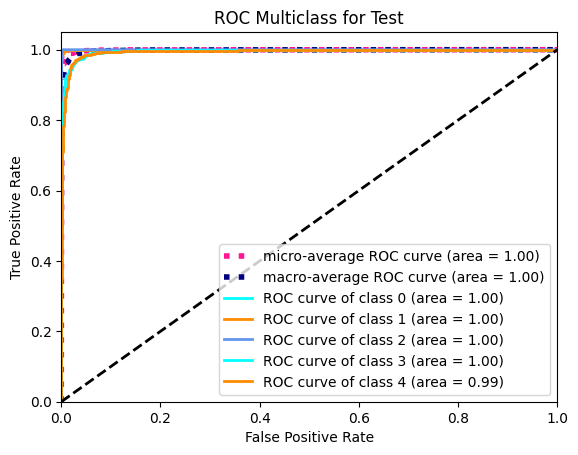

In [14]:
#ROC Curve analysis of Best Fine-tuned Model

plot_multiclass_roc(model_enhanced, X_val, y_val, n_classes=5, title='ROC Multiclass for Validation')
plot_multiclass_roc(model_enhanced, X_test, y_test, n_classes=5, title='ROC Multiclass for Test')



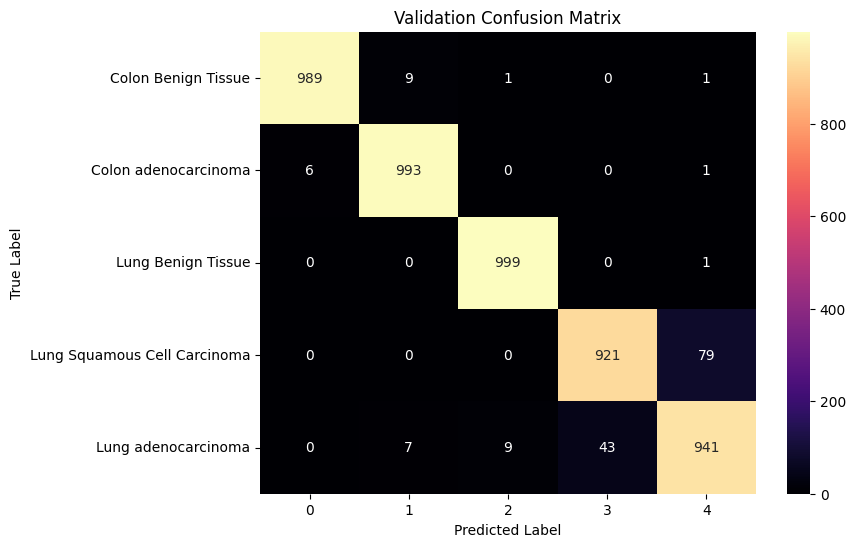

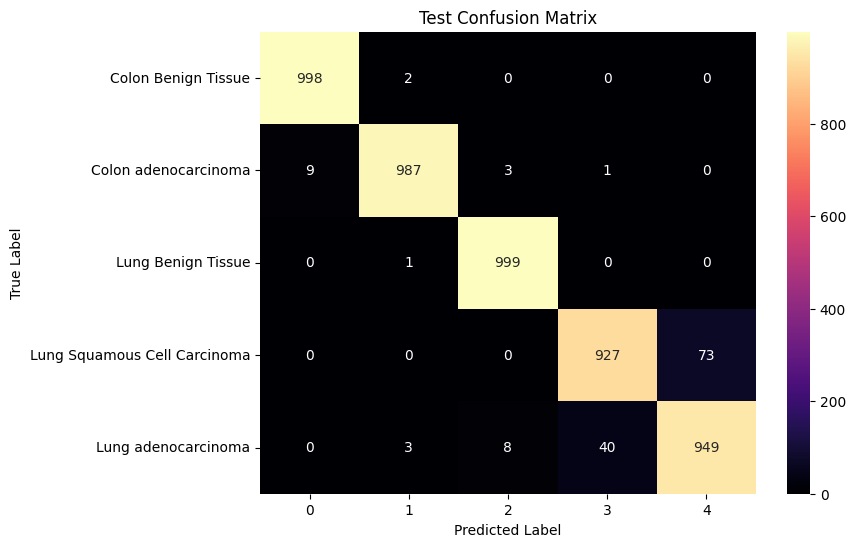

In [15]:
# Confusion matrix for the Best Fine-tuned Model

plot_confusion_matrix(y_val_decoded, y_val_pred_decoded, label_encoder,title= 'Validation Confusion Matrix')
plot_confusion_matrix(y_test_decoded, y_test_pred_decoded, label_encoder,title= 'Test Confusion Matrix')


In [12]:
#Performance Measure Report Best Fine-tuned Model

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       0.99      0.99      0.99      1000
           2       0.98      1.00      0.99      1000
           3       0.96      0.93      0.95      1000
           4       0.93      0.94      0.93      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       0.99      0.98      0.99      1000
           2       0.99      1.00      0.99      1000
           3       0.96      0.93      0.95      1000
           4       0.93      0.95      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [15]:
#Enhanced Model_1

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# input shape based on dataset's image dimensions and channels
input_shape = (120, 120, 3) 

# Number of classes
num_classes = 5  

model = Sequential([
    Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(32, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # softmax for multiclass classification
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # Suitable for multiclass classification
              metrics=['accuracy'])

model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 64)       

In [16]:
#Fitting the Enhanced model_1
import warnings
warnings.filterwarnings('ignore')

Baseline_hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

2024-03-08 21:38:12.525238: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/10


2024-03-08 21:38:14.395494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 16s 31ms/step - loss: 1.7470 - accuracy: 0.6375 - val_loss: 1.0868 - val_accuracy: 0.4932
Epoch 2/10
469/469 [==============================] - 13s 29ms/step - loss: 0.4503 - accuracy: 0.8065 - val_loss: 0.3578 - val_accuracy: 0.8552
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 0.3253 - accuracy: 0.8643 - val_loss: 0.3144 - val_accuracy: 0.8702
Epoch 4/10
469/469 [==============================] - 13s 27ms/step - loss: 0.2609 - accuracy: 0.8949 - val_loss: 0.1976 - val_accuracy: 0.9216
Epoch 5/10
469/469 [==============================] - 13s 27ms/step - loss: 0.2182 - accuracy: 0.9137 - val_loss: 0.2263 - val_accuracy: 0.9070
Epoch 6/10
469/469 [==============================] - 13s 27ms/step - loss: 0.1935 - accuracy: 0.9260 - val_loss: 0.1876 - val_accuracy: 0.9286
Epoch 7/10
469/469 [==============================] - 12s 27ms/step - loss: 0.1782 - accuracy: 0.9316 - val_loss: 0.1940 - val_accuracy: 0.9184
Epo

In [17]:
#Predictions with Enhanced model_1

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
#Decoding the prediction
y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

157/157 [==============================] - 1s 7ms/step


In [18]:
#Performance Measure Report Enhanced Model_1

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.94      0.94      0.94      1000
           2       0.99      1.00      0.99      1000
           3       0.93      0.91      0.92      1000
           4       0.92      0.91      0.91      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1000
           1       0.95      0.93      0.94      1000
           2       0.98      0.99      0.99      1000
           3       0.93      0.92      0.92      1000
           4       0.91      0.90      0.91      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [30]:
#Enhanced Model_2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#number of classes
num_classes = 5

# Define the input shape
input_shape = (120, 120, 3)   

# Initialize the model
model_enh = Sequential([
    Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax') 
])

# Compile the model
model_enh.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model_enh.summary()






Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 60, 60, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 60, 60, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 30, 30, 64)       

In [31]:
#Fitting the Enhanced model_2
enhanced_hist = model_enh.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


2024-03-07 00:32:05.333054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 10s 18ms/step - loss: 7.8005 - accuracy: 0.6233 - val_loss: 0.5050 - val_accuracy: 0.7614
Epoch 2/10
469/469 [==============================] - 8s 18ms/step - loss: 0.4653 - accuracy: 0.7949 - val_loss: 0.4212 - val_accuracy: 0.8012
Epoch 3/10
469/469 [==============================] - 8s 16ms/step - loss: 0.3696 - accuracy: 0.8451 - val_loss: 0.4283 - val_accuracy: 0.8330
Epoch 4/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2945 - accuracy: 0.8815 - val_loss: 0.3401 - val_accuracy: 0.8678
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2566 - accuracy: 0.8987 - val_loss: 0.4440 - val_accuracy: 0.8122
Epoch 6/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2268 - accuracy: 0.9124 - val_loss: 0.2144 - val_accuracy: 0.9204
Epoch 7/10
469/469 [==============================] - 8s 18ms/step - loss: 0.1995 - accuracy: 0.9209 - val_loss: 0.2250 - val_accuracy: 0.9070
Epoch 8/1

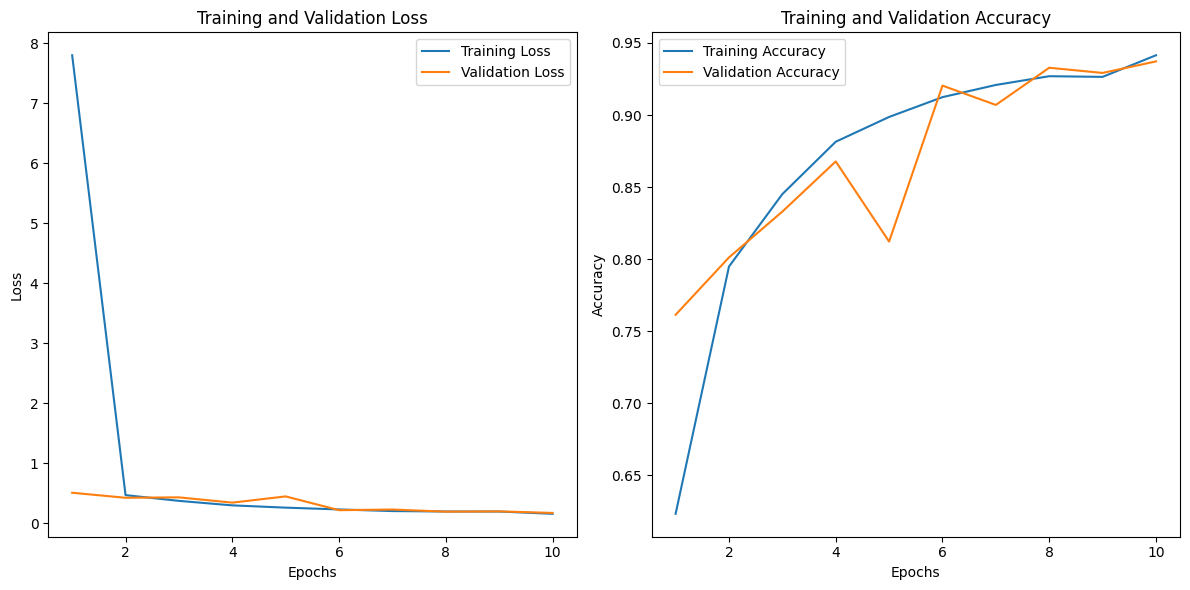

In [32]:
#Evaluating Loss and Accuracy of the Enhanced model_2

plot_loss_accuracy(enhanced_hist)

157/157 [==============================] - 1s 5ms/step


/tmp/ipykernel_649/3275120070.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


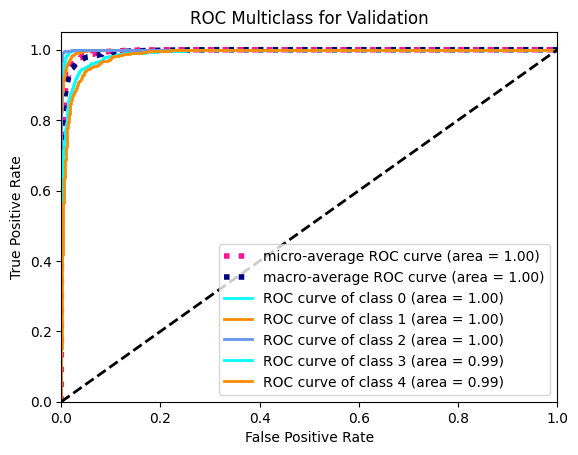

157/157 [==============================] - 1s 4ms/step


/tmp/ipykernel_649/3275120070.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


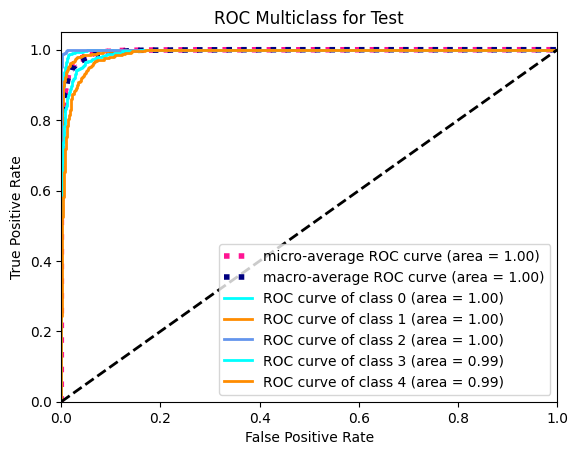

In [33]:
#ROC Curve analysis of Enhanced model_2

plot_multiclass_roc(model_enh, X_val, y_val, n_classes=5, title='ROC Multiclass for Validation')
plot_multiclass_roc(model_enh, X_test, y_test, n_classes=5, title='ROC Multiclass for Test')

157/157 [==============================] - 1s 4ms/step


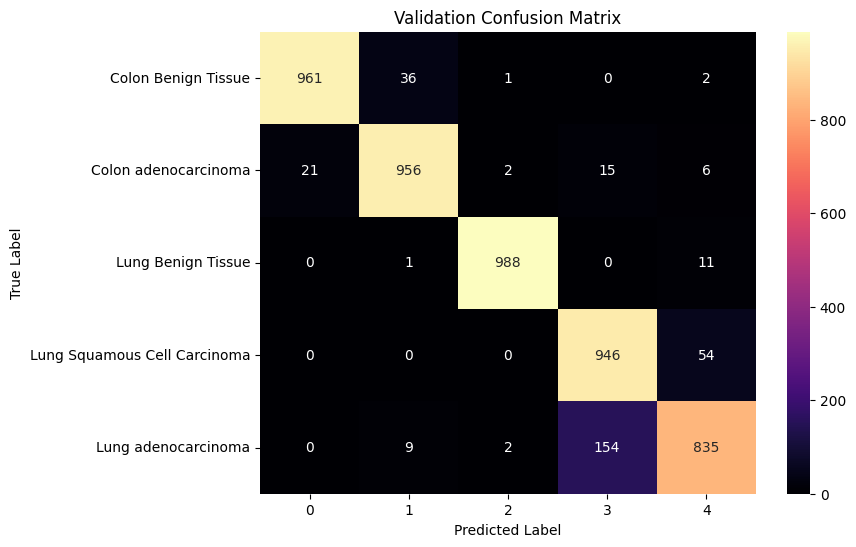

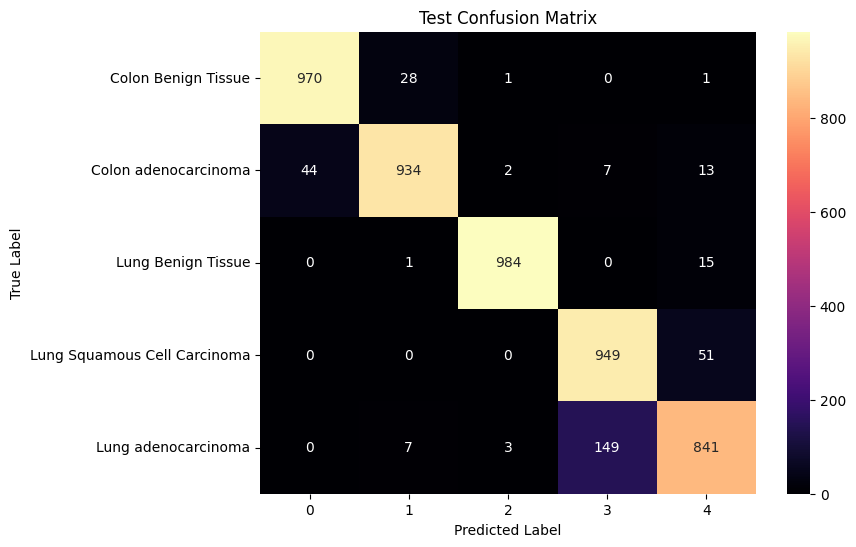

In [34]:
# Confusion matrix for the Enhanced model_2
y_val_pred = model_enh.predict(X_val)
y_test_pred = model_enh.predict(X_test)

y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

# Assuming y_true and y_pred are your true and predicted labels, respectively
plot_confusion_matrix(y_val_decoded, y_val_pred_decoded, label_encoder,title= 'Validation Confusion Matrix')
plot_confusion_matrix(y_test_decoded, y_test_pred_decoded, label_encoder,title= 'Test Confusion Matrix')

In [35]:
#Performance Measure Report Enhaced model_2

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.95      0.96      0.96      1000
           2       0.99      0.99      0.99      1000
           3       0.85      0.95      0.89      1000
           4       0.92      0.83      0.88      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1000
           1       0.96      0.93      0.95      1000
           2       0.99      0.98      0.99      1000
           3       0.86      0.95      0.90      1000
           4       0.91      0.84      0.88      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# Transfer Learning Model


In [8]:
# Transfer Learning Model VGG16
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

num_classes=5

# Loading the VGG16 model, pre-trained on ImageNet data, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freezing the layers of the base_model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x)  
x = Dense(32, activation='relu')(x)  
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

model_transfer.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_transfer.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [9]:
#Fitting Transfer Learning Model VGG16 15 epochs

transfer_hist = model_transfer.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
469/469 [==============================] - 22s 42ms/step - loss: 0.3438 - accuracy: 0.8900 - val_loss: 0.1586 - val_accuracy: 0.9408
Epoch 2/15
469/469 [==============================] - 17s 36ms/step - loss: 0.1190 - accuracy: 0.9537 - val_loss: 0.1370 - val_accuracy: 0.9486
Epoch 3/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0865 - accuracy: 0.9677 - val_loss: 0.1481 - val_accuracy: 0.9476
Epoch 4/15
469/469 [==============================] - 17s 37ms/step - loss: 0.0804 - accuracy: 0.9691 - val_loss: 0.1497 - val_accuracy: 0.9448
Epoch 5/15
469/469 [==============================] - 18s 39ms/step - loss: 0.0633 - accuracy: 0.9762 - val_loss: 0.1106 - val_accuracy: 0.9632
Epoch 6/15
469/469 [==============================] - 18s 37ms/step - loss: 0.0591 - accuracy: 0.9779 - val_loss: 0.1501 - val_accuracy: 0.9528
Epoch 7/15
469/469 [==============================] - 18s 38ms/step - loss: 0.0471 - accuracy: 0.9821 - val_loss: 0.1391 - val_accuracy:

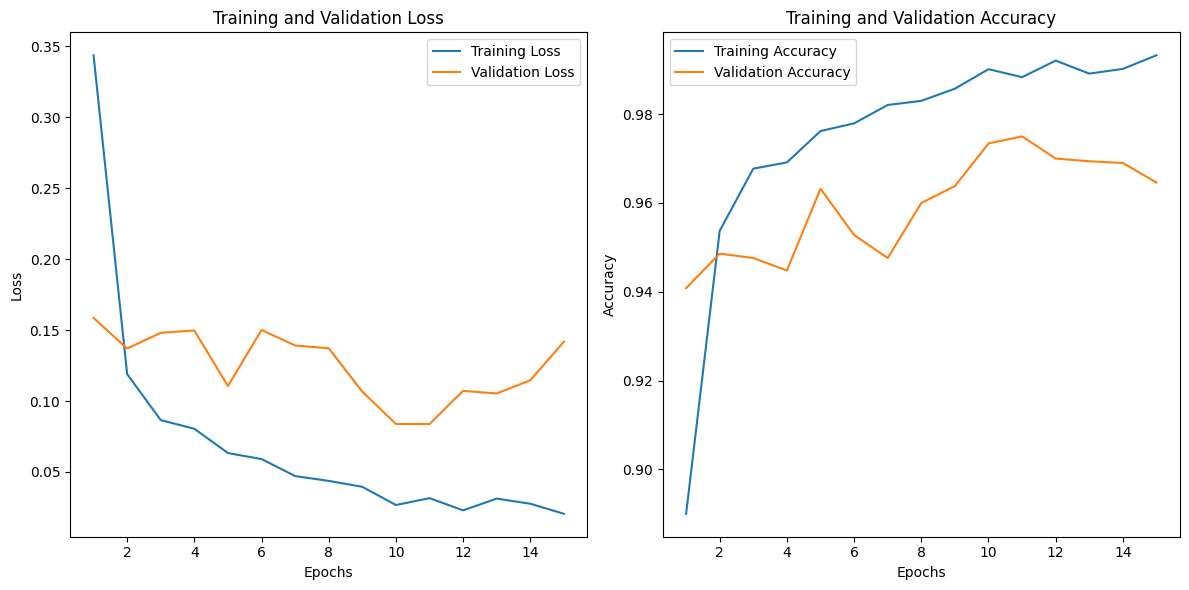

In [10]:
#Evaluating Loss and Accuracy of the Transfer model VGG16 15 epochs

plot_loss_accuracy(transfer_hist)

In [10]:
#Fitting Transfer Learning Model VGG16 10 epochs

transfer_hist = model_transfer.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 22s 40ms/step - loss: 0.3520 - accuracy: 0.8987 - val_loss: 0.1918 - val_accuracy: 0.9320
Epoch 2/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1185 - accuracy: 0.9559 - val_loss: 0.1101 - val_accuracy: 0.9574
Epoch 3/10
469/469 [==============================] - 17s 36ms/step - loss: 0.0762 - accuracy: 0.9711 - val_loss: 0.1461 - val_accuracy: 0.9510
Epoch 4/10
469/469 [==============================] - 17s 36ms/step - loss: 0.0674 - accuracy: 0.9741 - val_loss: 0.1106 - val_accuracy: 0.9596
Epoch 5/10
469/469 [==============================] - 17s 36ms/step - loss: 0.0581 - accuracy: 0.9774 - val_loss: 0.1592 - val_accuracy: 0.9428
Epoch 6/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0493 - accuracy: 0.9817 - val_loss: 0.0836 - val_accuracy: 0.9712
Epoch 7/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0293 - accuracy: 0.9896 - val_loss: 0.1025 - val_accuracy:

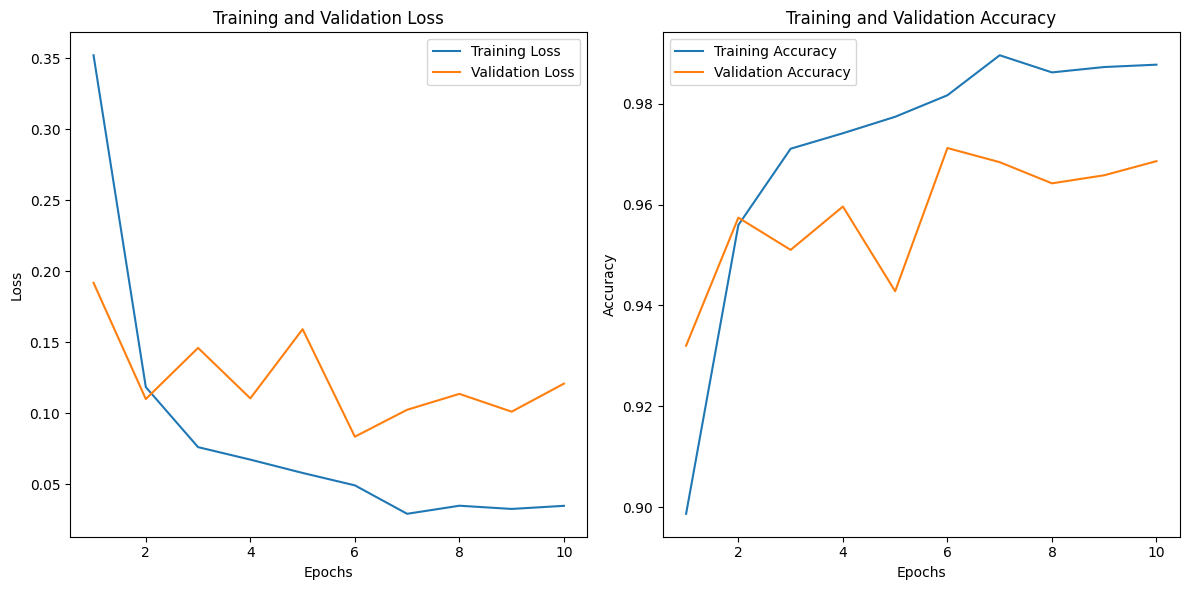

In [11]:
#Evaluating Loss and Accuracy of the Transfer model VGG16 10 epochs

plot_loss_accuracy(transfer_hist)

In [12]:
#Predictions with Transfer Learnign model VGG16 10 epochs

y_val_pred = model_transfer.predict(X_val)
y_test_pred = model_transfer.predict(X_test)

y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

157/157 [==============================] - 4s 25ms/step


157/157 [==============================] - 4s 24ms/step


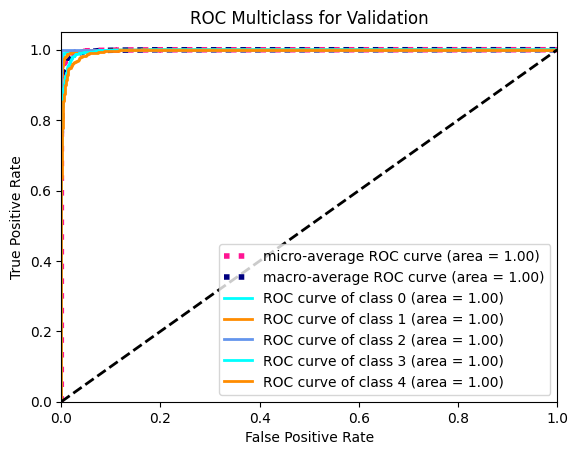

157/157 [==============================] - 4s 25ms/step


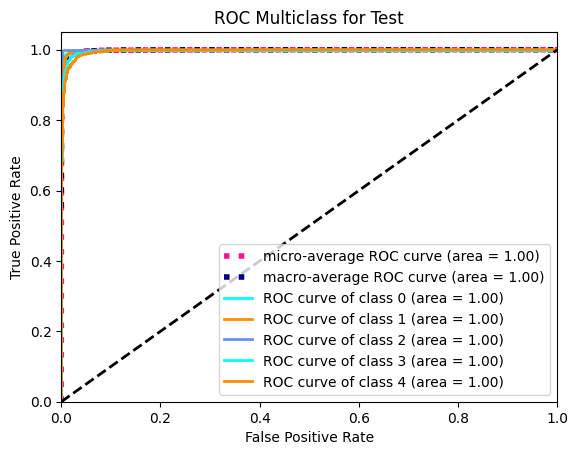

In [13]:
#ROC Curve analysis of Transfer Learning model VGG16 10 epochs
 
plot_multiclass_roc(model_transfer, X_val, y_val, n_classes=5, title='ROC Multiclass for Validation')
plot_multiclass_roc(model_transfer, X_test, y_test, n_classes=5, title='ROC Multiclass for Test')

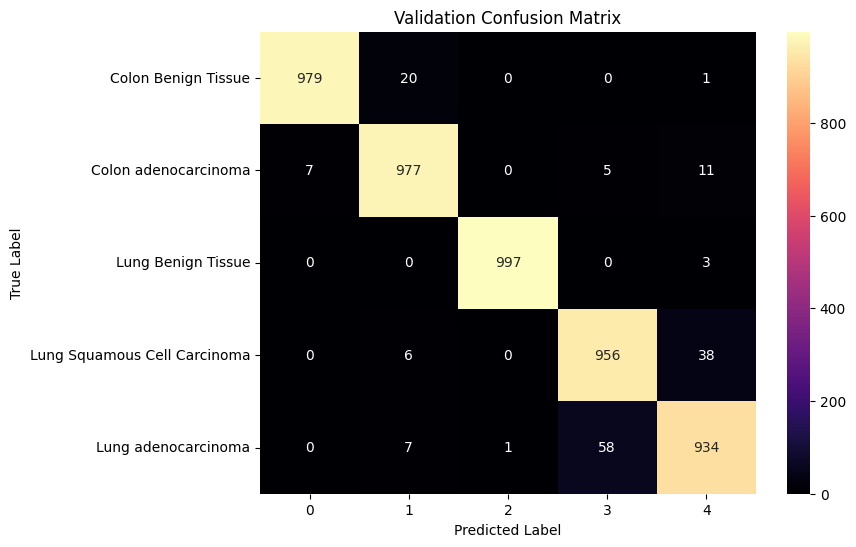

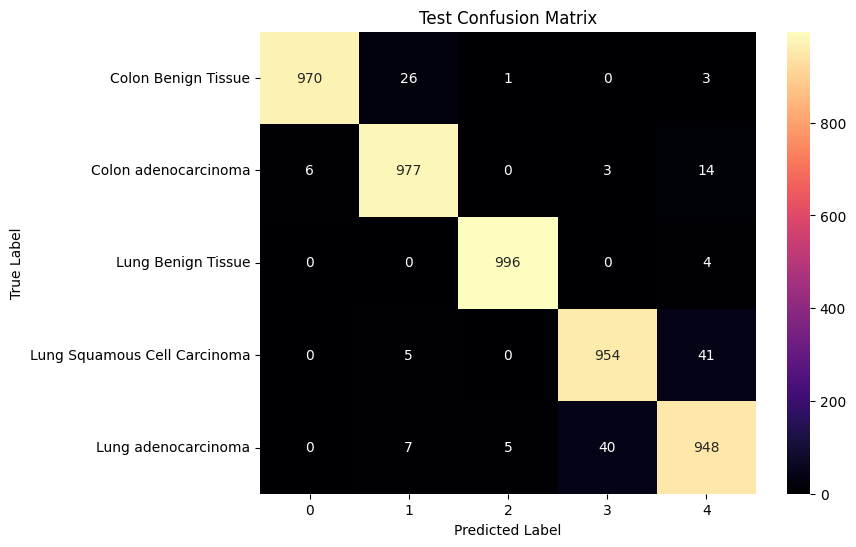

In [14]:
#Confusion matrix for Transfer Learning model VGG16 10 epochs

plot_confusion_matrix(y_val_decoded, y_val_pred_decoded, label_encoder,title= 'Validation Confusion Matrix')
plot_confusion_matrix(y_test_decoded, y_test_pred_decoded, label_encoder,title= 'Test Confusion Matrix')

In [15]:
#Performance Measure Report transfer Learning model VGG16 10 epochs

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1000
           1       0.97      0.98      0.97      1000
           2       1.00      1.00      1.00      1000
           3       0.94      0.96      0.95      1000
           4       0.95      0.93      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.96      0.98      0.97      1000
           2       0.99      1.00      1.00      1000
           3       0.96      0.95      0.96      1000
           4       0.94      0.95      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [8]:
#Transfer Learning Model DenseNet121
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Loading the DenseNet121 model pre-trained on ImageNet data
base_model = DenseNet121(weights='imagenet', include_top=False)

# Freezing the layers except the fully connected layers
for layer in base_model.layers:
    layer.trainable = False

# Create new model on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x)  
x = Dense(32, activation='relu')(x) 
 
num_classes = 5
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

model_transfer.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_transfer.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, None, None, 3)        0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']    

In [9]:
#Fitting the Transfer learning Model DenseNet 121

transfer_hist = model_transfer.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

2024-03-09 16:45:19.119497: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.
2024-03-09 16:45:19.663256: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/10


2024-03-09 16:45:24.370744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-09 16:45:24.835484: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 16:45:25.813117: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 16:45:25.899591: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55af3e6c70f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 16:45:25.899630: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-03-09 16:45:25.911528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-09 16:45:25.993424: I ./tensorflow/compiler/j

469/469 [==============================] - 25s 40ms/step - loss: 0.4375 - accuracy: 0.8407 - val_loss: 0.2445 - val_accuracy: 0.9048
Epoch 2/10
469/469 [==============================] - 17s 36ms/step - loss: 0.2499 - accuracy: 0.9008 - val_loss: 0.2852 - val_accuracy: 0.8948
Epoch 3/10
469/469 [==============================] - 16s 35ms/step - loss: 0.2083 - accuracy: 0.9142 - val_loss: 0.2685 - val_accuracy: 0.8996
Epoch 4/10
469/469 [==============================] - 16s 35ms/step - loss: 0.1889 - accuracy: 0.9232 - val_loss: 0.1734 - val_accuracy: 0.9306
Epoch 5/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1661 - accuracy: 0.9333 - val_loss: 0.1649 - val_accuracy: 0.9336
Epoch 6/10
469/469 [==============================] - 16s 35ms/step - loss: 0.1632 - accuracy: 0.9328 - val_loss: 0.1543 - val_accuracy: 0.9370
Epoch 7/10
469/469 [==============================] - 19s 40ms/step - loss: 0.1542 - accuracy: 0.9383 - val_loss: 0.2171 - val_accuracy: 0.9204
Epo

157/157 [==============================] - 5s 35ms/step


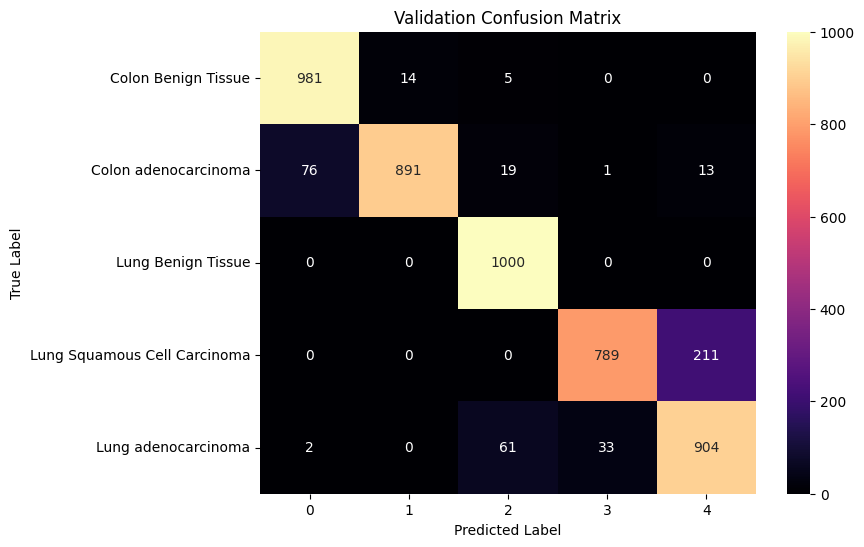

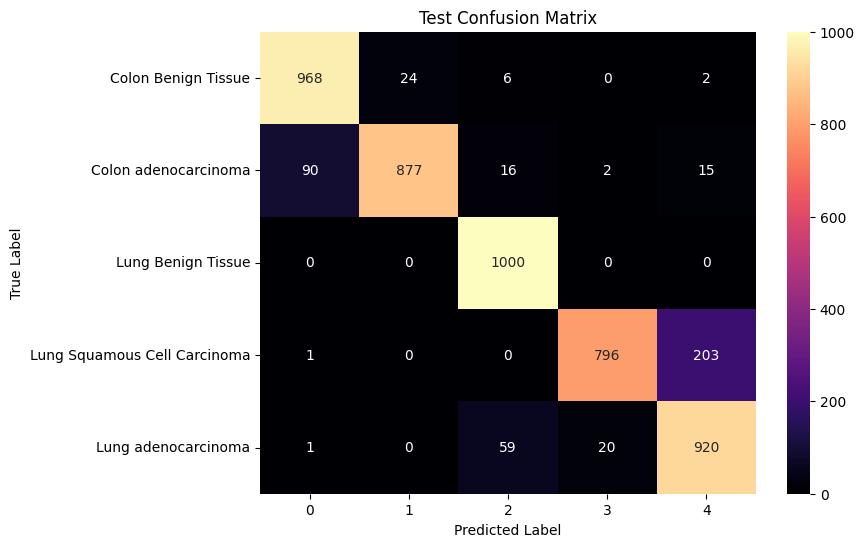

In [11]:
# Confusion matrix for the Transfer Learning model DenseNet121
y_val_pred = model_transfer.predict(X_val)
y_test_pred = model_transfer.predict(X_test)

y_val_decoded = np.argmax(y_val, axis=1)
y_val_pred_decoded = np.argmax(y_val_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)
y_test_pred_decoded = np.argmax(y_test_pred, axis=1)

plot_confusion_matrix(y_val_decoded, y_val_pred_decoded, label_encoder,title= 'Validation Confusion Matrix')
plot_confusion_matrix(y_test_decoded, y_test_pred_decoded, label_encoder,title= 'Test Confusion Matrix')

In [12]:
#Performance Measure Report Transfer Learning Model DenseNet121

print_classification_report(y_val_decoded, y_val_pred_decoded)
print_classification_report(y_test_decoded, y_test_pred_decoded)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1000
           1       0.98      0.89      0.94      1000
           2       0.92      1.00      0.96      1000
           3       0.96      0.79      0.87      1000
           4       0.80      0.90      0.85      1000

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1000
           1       0.97      0.88      0.92      1000
           2       0.93      1.00      0.96      1000
           3       0.97      0.80      0.88      1000
           4       0.81      0.92      0.86      1000

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000

